# IMPORTS

In [3]:
import pandas as pd
import numpy as np
from statsforecast import StatsForecast
from statsforecast.models import HistoricAverage, SeasonalNaive, SeasonalWindowAverage
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns 

c:\Users\ARuposh\Projects\license_forecasting_data\.venv\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
c:\Users\ARuposh\Projects\license_forecasting_data\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# READING DATASETS AND MERGING INTO ONE DATA FRAME

In [5]:
df1 = pd.read_csv('C:/Users/ARuposh/Downloads/neww.csv')
df2 = pd.read_csv('C:/Users/ARuposh/Downloads/TOTAL_SALES_PER_FISCAL_YEAR_MUSIC.csv')

# Merging and sorting the values 
df = df1.merge(df2, on='YEAR_ID', how='left')
df['DATE_ID'] = pd.to_datetime(df['DATE_ID'])
df = df.sort_values('DATE_ID')
df['TOTAL_WEEK_SALES'] = df['TOTAL_WEEK_SALES'].astype(float)

# CALCULATING BUSINESS INDEX 

In [6]:
# Calculating Businesss Index and handling division by zero
df['BI'] = np.where(df['TOTAL_WEEK_SALES'] == 0, 0, df['TOTAL_YEAR_SALES'] / df['TOTAL_WEEK_SALES'])


# CALCULATING THE CUTOFF ROLLING AVERAGE

In [7]:

cutoff = '2025-05-04'

# Cutoff version RA
df['RA_cutoff'] = df['TOTAL_WEEK_SALES'].rolling(window=52, min_periods=1).mean().where(df['DATE_ID'] <= cutoff)
cutoff_ra_value = df.loc[df['DATE_ID'] == cutoff, 'RA_cutoff'].iloc[0]
df.loc[df['DATE_ID'] > cutoff, 'RA_cutoff'] = cutoff_ra_value

# CALCULATING THE NON-CUTOFF ROLLING AVERAGE

In [8]:
# No-cutoff version RA
df['RA_no_cutoff'] = df['TOTAL_WEEK_SALES'].rolling(window=52, min_periods=1).mean()

# CALCULATING THE ROLLING AVERAGE x BUSINESS INDEX (FOR CUTOFF AND NON-CUTOFF)

In [9]:
# Calculate both versions of RA × BI
df['RA_X_BI_cutoff'] = df['BI'] * df['RA_cutoff']
df['RA_X_BI_no_cutoff'] = df['BI'] * df['RA_no_cutoff']


# CREATING A TRAIN DF AND TEST DF

In [10]:
#Train df
train_df = df[df['DATE_ID'] <= cutoff]

#Test df
test_df = df[df['DATE_ID'] > cutoff]

#Train Forecasting 
train_fcst = train_df[['DATE_ID', 'TOTAL_WEEK_SALES']].copy()
train_fcst = train_fcst.rename(columns={'DATE_ID': 'ds', 'TOTAL_WEEK_SALES': 'y'})
train_fcst['unique_id'] = 'MUSIC'


# FORECAST HORIZON 

In [11]:
fcst_hor = len(test_df)

# INSTANTIATE THE MODELS 

In [12]:
models = [
    HistoricAverage(),
    SeasonalNaive(season_length=52),
    SeasonalWindowAverage(season_length=52, window_size=2)
]

sf = StatsForecast(
    models=models,
    freq='W',
    n_jobs=1
)


models_26 = [
    HistoricAverage(),
    SeasonalNaive(season_length=26),
    SeasonalWindowAverage(season_length=26, window_size=2)
]

sf_26 = StatsForecast(
    models=models_26,
    freq='W',
    n_jobs=1
)

models_8 = [
    HistoricAverage(),
    SeasonalNaive(season_length=8),
    SeasonalWindowAverage(season_length=8, window_size=2)
]

sf_8 = StatsForecast(
    models=models_8,
    freq='W',
    n_jobs=1
)

# FIT AND FORECAST THE MODEL

In [13]:
pred = sf.forecast(df=train_fcst[['unique_id', 'ds', 'y']], h=fcst_hor)
pred_26 = sf_26.forecast(df=train_fcst[['unique_id', 'ds', 'y']], h=fcst_hor)
pred_8 = sf.forecast(df=train_fcst[['unique_id', 'ds', 'y']], h=fcst_hor)

# PREPARING TEST DATAFRAME

In [14]:
test_df = test_df[['DATE_ID', 'TOTAL_WEEK_SALES', 'RA_X_BI_cutoff', 'RA_X_BI_no_cutoff']].copy()
test_df = test_df.rename(columns={'DATE_ID': 'ds', 'TOTAL_WEEK_SALES': 'y'})
test_df['unique_id'] = 'MUSIC'

# COMBINING THE PREDICTED VALUES AND ACTUAL VALUES INTO ONE DATAFRAME

In [15]:
combined = test_df.merge(pred, on=['unique_id', 'ds'], how='left')
combined = combined.dropna()
combined['ds'] = pd.to_datetime(combined['ds'])

combined_26 = test_df.merge(pred_26, on=['unique_id', 'ds'], how='left')
combined_26 = combined_26.dropna()
combined_26['ds'] = pd.to_datetime(combined_26['ds'])

combined_8 = test_df.merge(pred_8, on=['unique_id', 'ds'], how='left')
combined_8 = combined_8.dropna()
combined_8['ds'] = pd.to_datetime(combined_8['ds'])


# CALCULATING MAPE FOR EACH MODEL


In [25]:

mape_historicavg = mean_absolute_percentage_error(combined['y'], combined['HistoricAverage'])
mape_sn = mean_absolute_percentage_error(combined['y'], combined['SeasonalNaive'])
mape_swa = mean_absolute_percentage_error(combined['y'], combined['SeasWA'])

print(f'52 Weeks:')
print()
print(f'HistoricAverage: MAPE = {mape_historicavg}')
print(f'SeasonalNaive: MAPE = {mape_sn}')
print(f'SeasonalWindowAverage: MAPE = {mape_swa}')
print()

#36 Week-----------------------------------------------------------------

mape_historicavg_26 = mean_absolute_percentage_error(combined_26['y'], combined_26['HistoricAverage'])
mape_sn_26 = mean_absolute_percentage_error(combined_26['y'], combined_26['SeasonalNaive'])
mape_swa_26 = mean_absolute_percentage_error(combined_26['y'], combined_26['SeasWA'])

print(f'26 Weeks:')
print()
print(f'HistoricAverage: MAPE = {mape_historicavg_26}')
print(f'SeasonalNaive: MAPE = {mape_sn_26}')
print(f'SeasonalWindowAverage: MAPE = {mape_swa_26}')
print()


#8 Week-----------------------------------------------------------------

mape_historicavg_8 = mean_absolute_percentage_error(combined_8['y'], combined_8['HistoricAverage'])
mape_sn_8 = mean_absolute_percentage_error(combined_8['y'], combined_8['SeasonalNaive'])
mape_swa_8 = mean_absolute_percentage_error(combined_8['y'], combined_8['SeasWA'])
print()


print(f'8 Weeks:')
print()
print(f'HistoricAverage: MAPE = {mape_historicavg_8}')
print(f'SeasonalNaive: MAPE = {mape_sn_8}')
print(f'SeasonalWindowAverage: MAPE = {mape_swa_8}')



52 Weeks:

HistoricAverage: MAPE = 0.09563971705175227
SeasonalNaive: MAPE = 0.3094250776605665
SeasonalWindowAverage: MAPE = 0.321298183007924

26 Weeks:

HistoricAverage: MAPE = 0.09563971705175227
SeasonalNaive: MAPE = 0.41661957221728724
SeasonalWindowAverage: MAPE = 0.23889703391750292


8 Weeks:

HistoricAverage: MAPE = 0.09563971705175227
SeasonalNaive: MAPE = 0.3094250776605665
SeasonalWindowAverage: MAPE = 0.321298183007924


# COMPARE CUTOFF RA x BI TO NON-CUTOFF RA x BI

In [26]:
mape_comparison = mean_absolute_percentage_error(combined['RA_X_BI_cutoff'], combined['RA_X_BI_no_cutoff'])

print(f'52 Weeks:')
print(f'RA × BI Cutoff vs No-Cutoff: MAPE = {mape_comparison}')
print()

mape_comparison_26 = mean_absolute_percentage_error(combined_26['RA_X_BI_cutoff'], combined_26['RA_X_BI_no_cutoff'])

print(f'26 Weeks:')
print(f'RA × BI Cutoff vs No-Cutoff: MAPE = {mape_comparison_26}')
print()

mape_comparison_8 = mean_absolute_percentage_error(combined_8['RA_X_BI_cutoff'], combined_8['RA_X_BI_no_cutoff'])

print(f'8 Weeks:')
print(f'RA × BI Cutoff vs No-Cutoff: MAPE = {mape_comparison_26}')


52 Weeks:
RA × BI Cutoff vs No-Cutoff: MAPE = 0.05816470703634702

26 Weeks:
RA × BI Cutoff vs No-Cutoff: MAPE = 0.05816470703634702

8 Weeks:
RA × BI Cutoff vs No-Cutoff: MAPE = 0.05816470703634702


# Creating results df with mapes, actuals, predictions and the rest of the columns from the orignial dfs


In [18]:
results = df.copy()
combined_for_merge = combined.copy()
combined_for_merge = combined_for_merge.rename(columns={'ds': 'DATE_ID', 'y': 'ACTUAL_SALES'})

# Merge predictions into the results dataframe


In [19]:
results = results.merge(combined_for_merge[['DATE_ID', 'HistoricAverage', 'SeasonalNaive', 'SeasWA']], on='DATE_ID', how='left')

# Adding evaluation metrics as columns


In [27]:

results['MAPE_HistoricAverage'] = mape_historicavg
results['MAPE_SeasonalNaive'] = mape_sn
results['MAPE_SeasonalWindowAverage'] = mape_swa
results['MAPE_RA_BI_Comparison'] = mape_comparison

# Saving into one dataframe

In [28]:
results.to_csv('results_baseline_fcst.csv', index = False)


# Calculating Residuals For Visualizations

In [29]:
combined['resid_HistoricAverage'] = combined['y'] - combined['HistoricAverage']
combined['resid_SeasonalNaive'] = combined['y'] - combined['SeasonalNaive']
combined['resid_SeasWA'] = combined['y'] - combined['SeasWA']

combined_26['resid_HistoricAverage'] = combined_26['y'] - combined_26['HistoricAverage']
combined_26['resid_SeasonalNaive'] = combined_26['y'] - combined_26['SeasonalNaive']
combined_26['resid_SeasWA'] = combined_26['y'] - combined_26['SeasWA']

combined_8['resid_HistoricAverage'] = combined_8['y'] - combined_8['HistoricAverage']
combined_8['resid_SeasonalNaive'] = combined_8['y'] - combined_8['SeasonalNaive']
combined_8['resid_SeasWA'] = combined_8['y'] - combined_8['SeasWA']



# Plotting Actual vs Forecasts (Including 26 Weeks and 8 Weeks Forecasts)

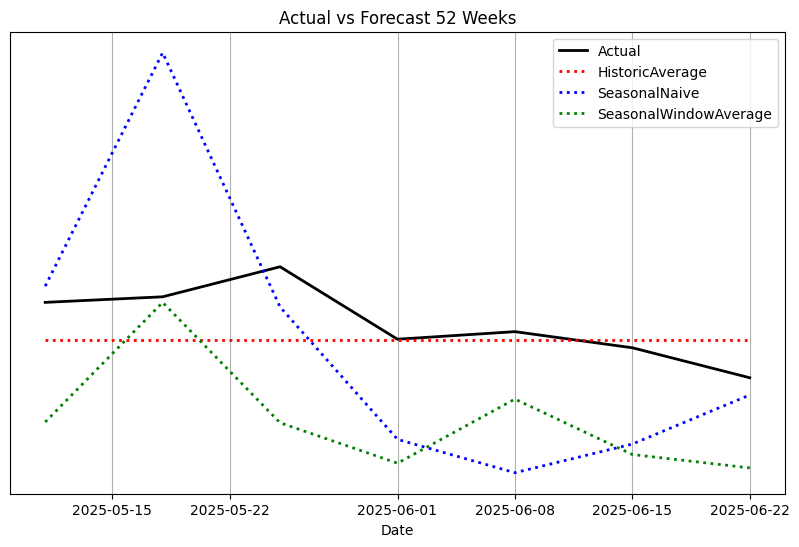

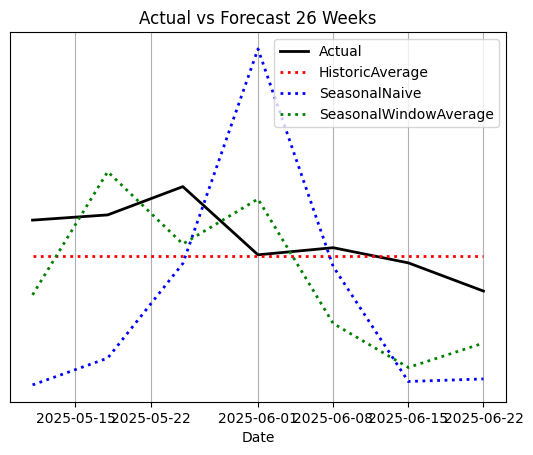

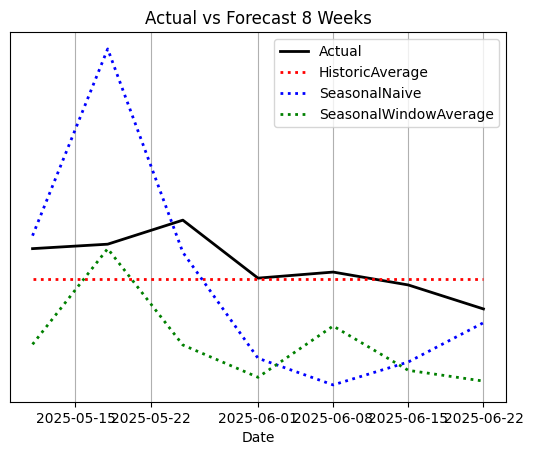

In [ ]:
plt.figure(figsize=(10, 6))

plot_df = combined[['ds', 'y', 'HistoricAverage', 'SeasonalNaive', 'SeasWA']].dropna()

plt.plot(plot_df['ds'], plot_df['y'], label='Actual', color='black', linewidth=2)
plt.plot(plot_df['ds'], plot_df['HistoricAverage'], label='HistoricAverage', color='red', linewidth=2, linestyle = ':')
plt.plot(plot_df['ds'], plot_df['SeasonalNaive'], label='SeasonalNaive', color='blue', linewidth=2, linestyle = ':')
plt.plot(plot_df['ds'], plot_df['SeasWA'], label='SeasonalWindowAverage', color = 'green', linewidth=2, linestyle = ':')
plt.title('Actual vs Forecast 52 Weeks')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.gca().axes.get_yaxis().set_visible(False)
plt.grid(True)
plt.show()

# 26 Week Plot -----------------------------------------------------------------------------

plot26_df = combined_26[['ds', 'y', 'HistoricAverage', 'SeasonalNaive', 'SeasWA']].dropna()

plt.plot(plot26_df['ds'], plot26_df['y'], label='Actual', color='black', linewidth=2)
plt.plot(plot26_df['ds'], plot26_df['HistoricAverage'], label='HistoricAverage', color='red', linewidth=2, linestyle = ':')
plt.plot(plot26_df['ds'], plot26_df['SeasonalNaive'], label='SeasonalNaive', color='blue', linewidth=2, linestyle = ':')
plt.plot(plot26_df['ds'], plot26_df['SeasWA'], label='SeasonalWindowAverage', color = 'green', linewidth=2, linestyle = ':')
plt.title('Actual vs Forecast 26 Weeks')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.gca().axes.get_yaxis().set_visible(False)
plt.grid(True)
plt.show()

# 8 Week Plot -----------------------------------------------------------------------------

plot8_df = combined_8[['ds', 'y', 'HistoricAverage', 'SeasonalNaive', 'SeasWA']].dropna()

plt.plot(plot8_df['ds'], plot8_df['y'], label='Actual', color='black', linewidth=2)
plt.plot(plot8_df['ds'], plot8_df['HistoricAverage'], label='HistoricAverage', color='red', linewidth=2, linestyle = ':')
plt.plot(plot8_df['ds'], plot8_df['SeasonalNaive'], label='SeasonalNaive', color='blue', linewidth=2, linestyle = ':')
plt.plot(plot8_df['ds'], plot8_df['SeasWA'], label='SeasonalWindowAverage', color = 'green', linewidth=2, linestyle = ':')
plt.title('Actual vs Forecast 8 Weeks')
plt.xlabel('Date')
plt.legend()
plt.gca().axes.get_yaxis().set_visible(False) 
plt.grid(True)
plt.show()


# Plot of Cutoff vs No-Cutoff (Including 26 Weeks and 8 Weeks Forecasts)

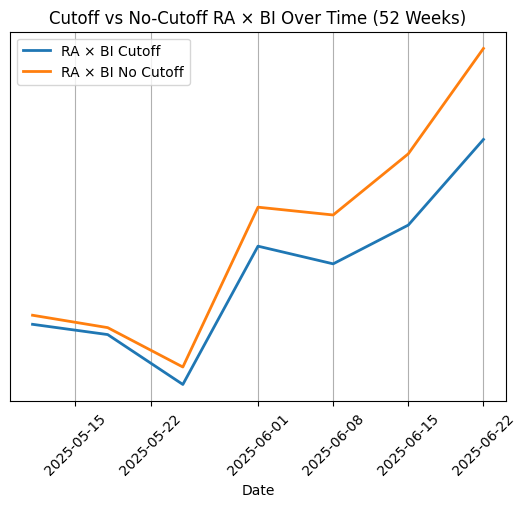

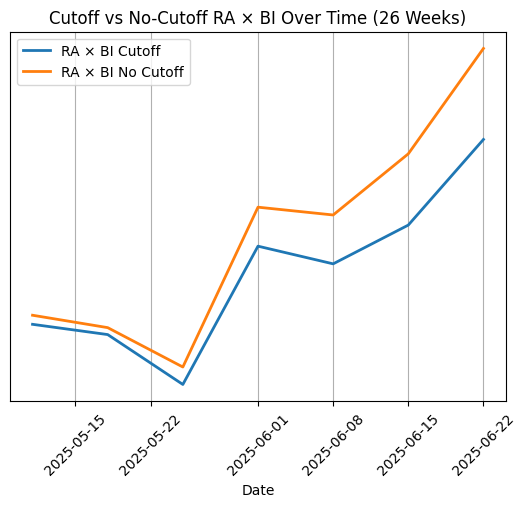

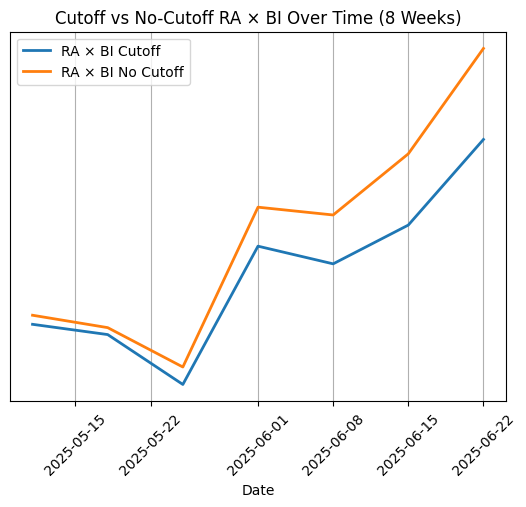

In [30]:
plt.plot(combined['ds'], combined['RA_X_BI_cutoff'], label='RA × BI Cutoff', linewidth=2)
plt.plot(combined['ds'], combined['RA_X_BI_no_cutoff'], label='RA × BI No Cutoff', linewidth=2)
plt.xlabel('Date')
plt.ylabel('RA × BI Values')
plt.title('Cutoff vs No-Cutoff RA × BI Over Time (52 Weeks)')
plt.legend()
plt.gca().axes.get_yaxis().set_visible(False)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

#26 Weeks ------------------------------------------------------------------------------------
plt.plot(combined_26['ds'], combined_26['RA_X_BI_cutoff'], label='RA × BI Cutoff', linewidth=2)
plt.plot(combined_26['ds'], combined_26['RA_X_BI_no_cutoff'], label='RA × BI No Cutoff', linewidth=2)
plt.xlabel('Date')
plt.ylabel('RA × BI Values')
plt.title('Cutoff vs No-Cutoff RA × BI Over Time (26 Weeks)')
plt.legend()
plt.gca().axes.get_yaxis().set_visible(False)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

#8 Weeks ------------------------------------------------------------------------------------
plt.plot(combined_8['ds'], combined_8['RA_X_BI_cutoff'], label='RA × BI Cutoff', linewidth=2)
plt.plot(combined_8['ds'], combined_8['RA_X_BI_no_cutoff'], label='RA × BI No Cutoff', linewidth=2)
plt.xlabel('Date')
plt.ylabel('RA × BI Values')
plt.title('Cutoff vs No-Cutoff RA × BI Over Time (8 Weeks)')
plt.legend()
plt.gca().axes.get_yaxis().set_visible(False)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Density Plot of Residuals (Including 26 Weeks and 8 Weeks Forecasts)

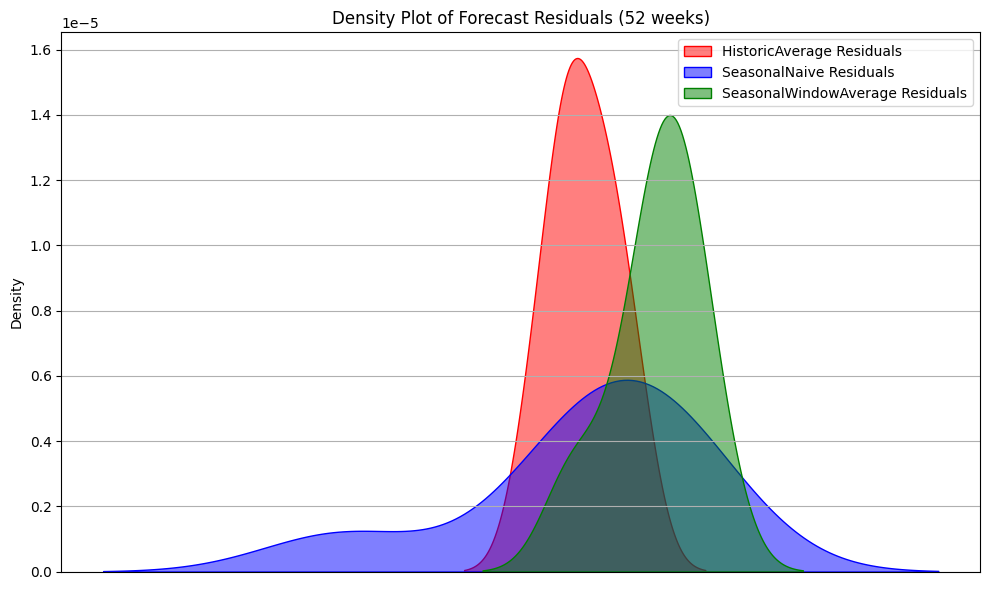

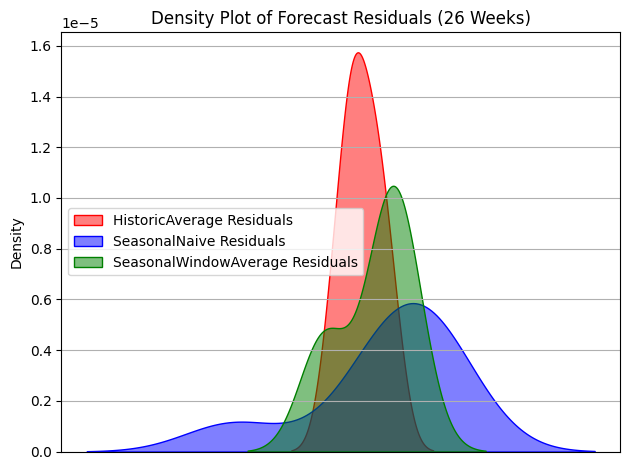

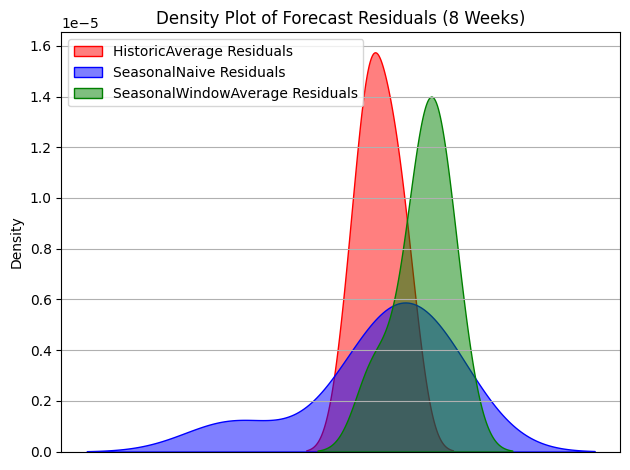

In [31]:
plt.figure(figsize=(10, 6))
sns.kdeplot(combined['resid_HistoricAverage'], label='HistoricAverage Residuals', fill=True, color='red', alpha=0.5)
sns.kdeplot(combined['resid_SeasonalNaive'], label='SeasonalNaive Residuals', fill=True, color='blue', alpha=0.5)
sns.kdeplot(combined['resid_SeasWA'], label='SeasonalWindowAverage Residuals', fill=True, color='green', alpha=0.5)

plt.title('Density Plot of Forecast Residuals (52 weeks)')
plt.xlabel('Residual (Actual - Forecast)')
plt.ylabel('Density')
plt.legend()
plt.gca().axes.get_xaxis().set_visible(False)
plt.grid(True)
plt.tight_layout()
plt.show()

#26 Weeks ----------------------------------------------------------------------------------------------------------------

sns.kdeplot(combined_26['resid_HistoricAverage'], label='HistoricAverage Residuals', fill=True, color='red', alpha=0.5)
sns.kdeplot(combined_26['resid_SeasonalNaive'], label='SeasonalNaive Residuals', fill=True, color='blue', alpha=0.5)
sns.kdeplot(combined_26['resid_SeasWA'], label='SeasonalWindowAverage Residuals', fill=True, color='green', alpha=0.5)

plt.title('Density Plot of Forecast Residuals (26 Weeks)')
plt.xlabel('Residual (Actual - Forecast)')
plt.ylabel('Density')
plt.legend()
plt.gca().axes.get_xaxis().set_visible(False)
plt.grid(True)
plt.tight_layout()
plt.show()

#8 Weeks ----------------------------------------------------------------------------------------------------------------

sns.kdeplot(combined_8['resid_HistoricAverage'], label='HistoricAverage Residuals', fill=True, color='red', alpha=0.5)
sns.kdeplot(combined_8['resid_SeasonalNaive'], label='SeasonalNaive Residuals', fill=True, color='blue', alpha=0.5)
sns.kdeplot(combined_8['resid_SeasWA'], label='SeasonalWindowAverage Residuals', fill=True, color='green', alpha=0.5)

plt.title('Density Plot of Forecast Residuals (8 Weeks)')
plt.xlabel('Residual (Actual - Forecast)')
plt.ylabel('Density')
plt.legend()
plt.gca().axes.get_xaxis().set_visible(False)
plt.grid(True)
plt.tight_layout()
plt.show()

